## 0. Import Packages

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import cv2
import imghdr
from matplotlib import pyplot as plt
import glob
from skimage import color, exposure

from sklearn.metrics import (confusion_matrix, classification_report, ConfusionMatrixDisplay)

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping

#Establish Evaluation Functions
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
cm = confusion_matrix

2023-05-11 10:32:11.969449: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### 0.1 Avoid OOM errors - limit tensorflow from using all of the vram on our machine.

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    f.config.experimental.set_memory_growth(gpu, True)

## 1. Import Data

#### 1.1 Gather Data

Note, data from this project was provided directly from WindowsWear, a company that manages a database of retail images. These images were provided in high resolution, due to commercial interests the company requested that only low resolution photos be used and published for this project.
Prior to import: these images were downloaded from dropbox, compressed to lower resolution using Adobe Bridge, and manually sorted into two folders - images containing mannequins and images not containing mannequins. 
This data is published on my github: https://github.com/chase-weber/Mannequin-Image-Detection

#### 1.2 Establish a Data Directory

In [3]:
# Establish data directory - data can be downloaded from my github - see above.
data_dir = '/Users/chaseweber/Desktop/Springboard/Github/Mannequin-Image-Detection/data'

# Establish acceptable image formats
image_ext = ['jpeg', 'jpg']

In [4]:
# Check data directory - list of folders should be listed
os.listdir(data_dir)

## In some cases, apple includes a '.DS_Store' in the data folder. Use terminal to navigate to the data folder and use the code below to delete. 
# find . -name '.DS_Store' -type f -delete 

['mannequin', '.DS_Store', 'other']

In [5]:
# List the images in each folder
# os.listdir(os.path.join(data_dir, 'other'))

#### 1.3 Check Images

In [6]:
img = cv2.imread(os.path.join(data_dir, 'other', 'image_000013.jpeg'))

In [7]:
img.shape

(300, 200, 3)

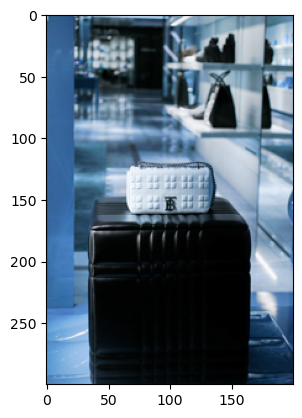

In [8]:
plt.imshow(img)
plt.show()

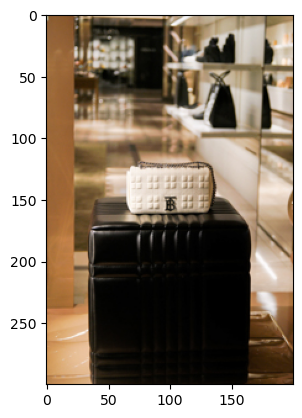

In [9]:
# Show with corrected color
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

#### 1.4 Load Data

In [10]:
# Explore the documentation for tf.keras.utils.image_dataset_from_directory
#tf.keras.utils.image_dataset_from_directory??

In [11]:
# Use keras to create an image dataset
## Batch size of 32 - default
## Size 300, 300
## Grayscale
data = tf.keras.utils.image_dataset_from_directory(data_dir, batch_size = 10, color_mode = 'grayscale', image_size = (300, 300))

Found 4912 files belonging to 2 classes.


In [12]:
data

<BatchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

#### 1.5 Use Numpy Iterator to Iterate through Images

In [13]:
# Initiate iterator to explore imported data
# NOTE: data is actually a data generator, an iterator is required to access the data.
data_iterator = data.as_numpy_iterator()

In [14]:
# Create batch that iterates through our data
batch = data_iterator.next()
# batch

In [15]:
len(data)

492

In [16]:
# Notice there are two parts, and image part and a label part
len(batch)

2

In [17]:
# Images represented as Numpy Arrays
batch[0].shape

(10, 300, 300, 1)

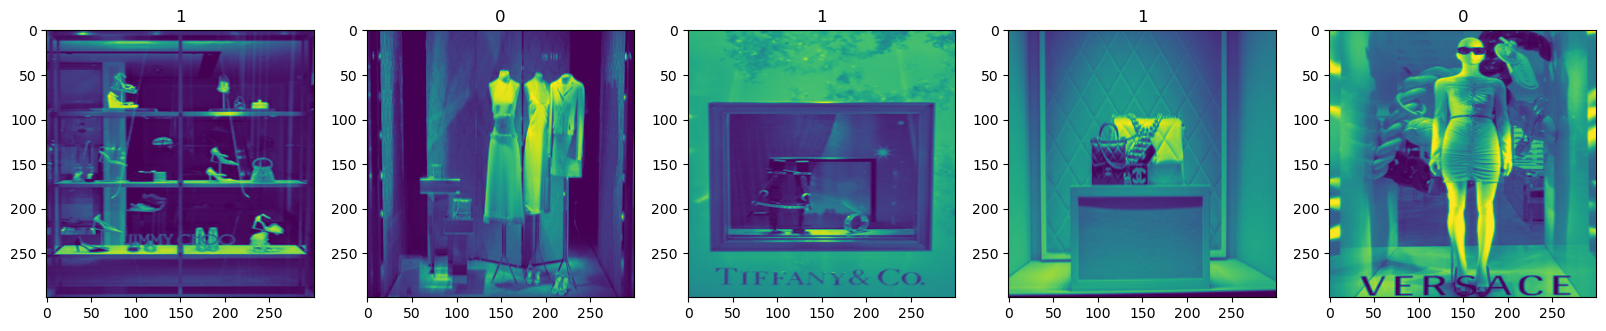

In [18]:
# Determine which label class represents which photo class
fig, ax = plt.subplots(ncols = 5, figsize = (20, 20))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Based on the above, we see that 0 represents cases with mannequins while 1 represents cases without mannequins. 
Images are imported as black and white.

## 2. Additional Data Manipulations

#### 2.1 Scale Images
#### Ensure that all images are scaled between 0 and 1

In [19]:
data2 = data.map(lambda x,y: (x/300, y))

In [20]:
# Check that the images were scaled correctly
scaled_iterator = data2.as_numpy_iterator()
batch = scaled_iterator.next()
print(batch[1].min())
print(batch[1].max())

0
1


#### 2.2 Sharpen Images
#### Increase the contrast in each image to better capture presense of mannequin

In [21]:
data2 = data2.map(lambda x,y: (tf.image.adjust_contrast(x, .7), y))

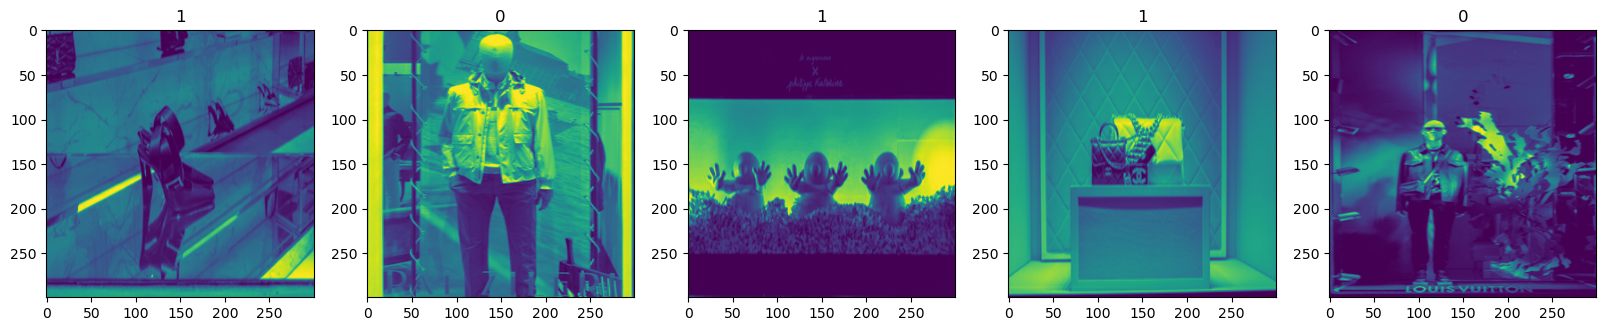

In [22]:
# Check the updated images
scaled_iterator = data2.as_numpy_iterator()
batch = scaled_iterator.next()
fig, ax = plt.subplots(ncols = 5, figsize = (20, 20))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img)
    #ax[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[idx].title.set_text(batch[1][idx])

#### 2.3 Crop Images
#### Crop to images to about 85% of the original width and 90% of the original height to avoid unnecessary noise 

In [23]:
data2 = data2.map(lambda x,y: (tf.image.crop_to_bounding_box(x, 10, 20, 250, 220), y))

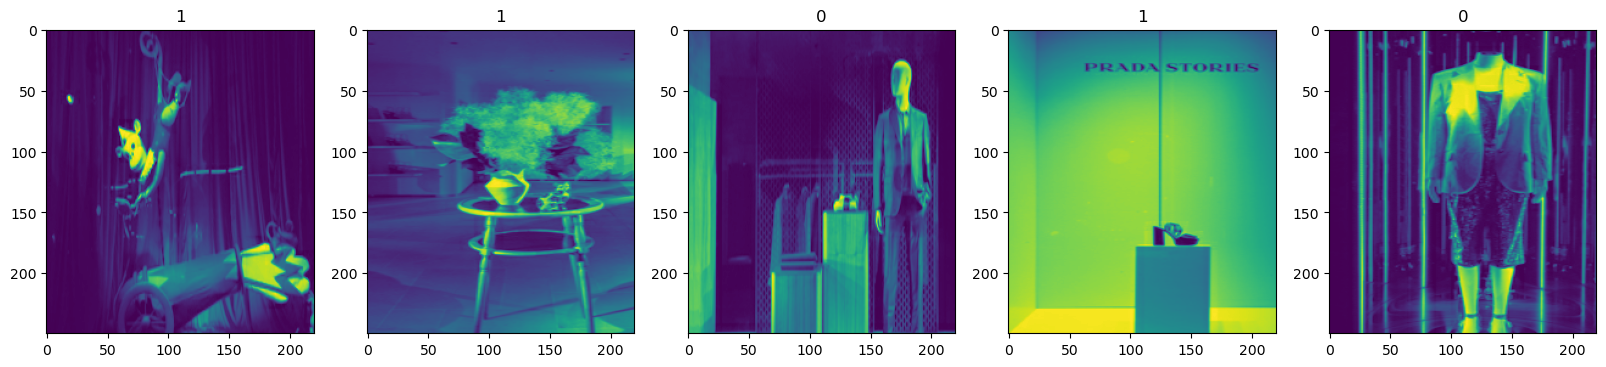

In [24]:
# Check the images were cropped correctly
scaled_iterator = data2.as_numpy_iterator()
batch = scaled_iterator.next()
fig, ax = plt.subplots(ncols = 5, figsize = (20, 20))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img)
    #ax[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[idx].title.set_text(batch[1][idx])

#### 2.4 Random Flip Images
#### Apply a random vertical flip to each image to create a more diverse dataset

In [25]:
data2 = data2.map(lambda x,y: (tf.image.random_flip_left_right(x, 123), y))

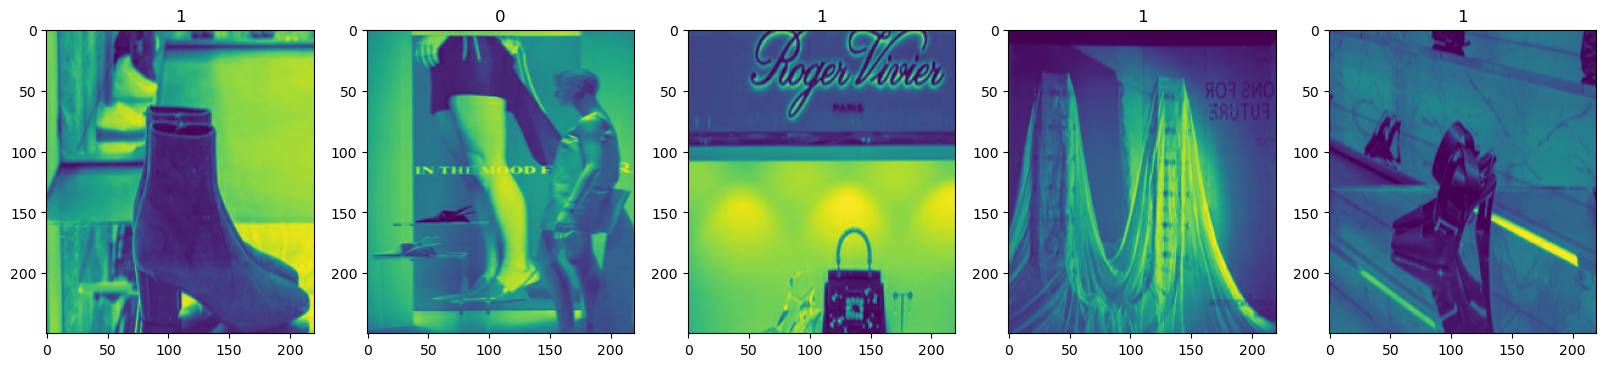

In [26]:
# Check flipped images
scaled_iterator = data2.as_numpy_iterator()
batch = scaled_iterator.next()
fig, ax = plt.subplots(ncols = 5, figsize = (20, 20))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img)
    #ax[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[idx].title.set_text(batch[1][idx])

#### 2.5 Shuffle Data

In [27]:
data2 = data2.shuffle(10, seed=123, reshuffle_each_iteration=None)

## 3. Exploratory Data Analysis

#### 3.1 Is our data imballanced?

In [28]:
number_classes = {'Class_Mannequin': len(os.listdir(os.path.join(data_dir, 'mannequin'))),
                 'Class_Other': len(os.listdir(os.path.join(data_dir, 'other')))}

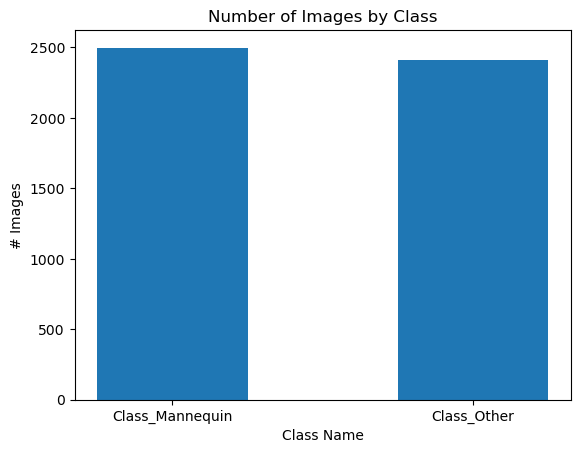

In [29]:
plt.bar(number_classes.keys(), number_classes.values(), width = .5);
plt.title("Number of Images by Class");
plt.xlabel('Class Name');
plt.ylabel('# Images');

In [30]:
number_classes.values()

dict_values([2499, 2413])

Based on the counts above, there doesn't appear to be too much of an imballance in our data.

#### 3.2 Show examples of images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IMAGES BEFORE CLEANING: 


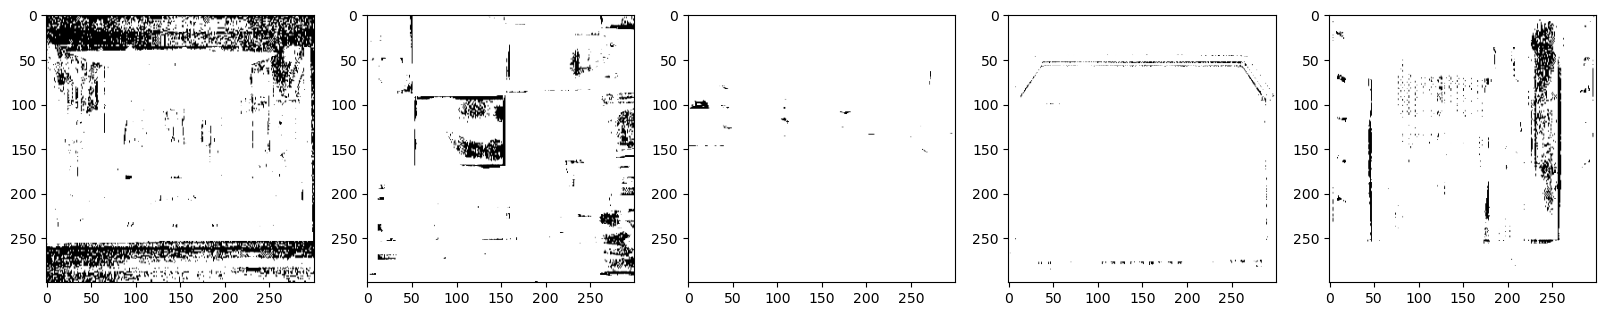

In [31]:
# Print out images for display
print("IMAGES BEFORE CLEANING: ")
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols = 5, figsize = (20, 20))
for idx, img in enumerate(batch[0][:5]):
    #ax[idx].imshow(img)
    ax[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

IMAGES AFTER CLEANING: 


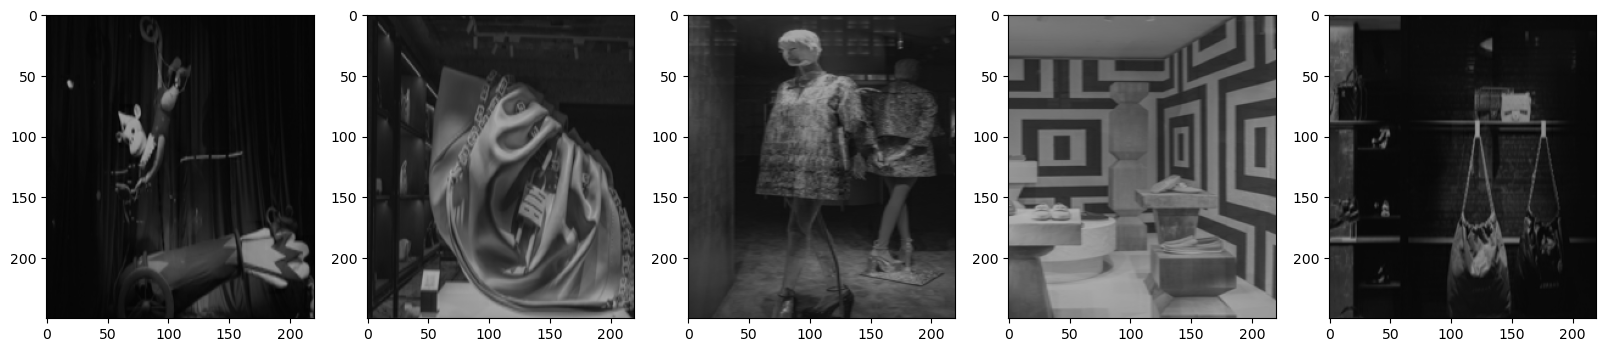

In [32]:
# Show enhanced and cropped images
print("IMAGES AFTER CLEANING: ")
data_iterator = data2.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols = 5, figsize = (20, 20))
for idx, img in enumerate(batch[0][:5]):
    #ax[idx].imshow(img)
    ax[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# 4. Pre-Processing

#### 4.1 Split the data

In [33]:
# Establish Size of Training, Test, and Validation splits
print(len(data2))
train_size = int(len(data2) * .7)
val_size = int(len(data2) * .2)
test_size = int(len(data2) * .1)
print(train_size)
print(val_size)
print(test_size)

492
344
98
49


In [34]:
# Create train, val, and test sets
train = data2.take(train_size)
val = data2.skip(train_size).take(val_size)
test = data2.skip(train_size+val_size).take(test_size)

In [35]:
# Check the length of the test set
len(test)

49

# 5. Model Training

### Reference notebook 2. Model Training for the model training process. 

# 6. Modeling

#### 6.1 Run the final selected model 

In [36]:
model = Sequential()
model.add(Conv2D(16, (2,2), 1, activation = 'relu', input_shape = (250,220,1)))
model.add(MaxPooling2D())
model.add(Dropout(.25))

model.add(Conv2D(32, (2,2), 1, activation = 'relu'))
model.add(MaxPooling2D())
model.add(Dropout(.25))

model.add(Conv2D(16, (2,2), 1, activation = 'relu'))
model.add(MaxPooling2D())
model.add(Dropout(.25))

model.add(Conv2D(32, (2,2), 1, activation = 'relu'))
model.add(MaxPooling2D())
model.add(Dropout(.25))

model.add(Conv2D(16, (2,2), 1, activation = 'relu'))
model.add(MaxPooling2D())
model.add(Dropout(.25))

model.add(Flatten())

model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

#### 6.2 Fit the final selected model

In [37]:
hist_initial = model.fit(train, validation_data=val, epochs = 20)

Epoch 1/20
344/344 [==============================] - 24s 68ms/step - loss: 0.6717 - accuracy: 0.5791 - val_loss: 0.6673 - val_accuracy: 0.5959
Epoch 2/20
344/344 [==============================] - 24s 68ms/step - loss: 0.5838 - accuracy: 0.7017 - val_loss: 0.6058 - val_accuracy: 0.7122
Epoch 3/20
344/344 [==============================] - 24s 69ms/step - loss: 0.5460 - accuracy: 0.7317 - val_loss: 0.5803 - val_accuracy: 0.7061
Epoch 4/20
344/344 [==============================] - 24s 71ms/step - loss: 0.5260 - accuracy: 0.7468 - val_loss: 0.5492 - val_accuracy: 0.7347
Epoch 5/20
344/344 [==============================] - 25s 72ms/step - loss: 0.5023 - accuracy: 0.7613 - val_loss: 0.5105 - val_accuracy: 0.7357
Epoch 6/20
344/344 [==============================] - 25s 74ms/step - loss: 0.4864 - accuracy: 0.7663 - val_loss: 0.5061 - val_accuracy: 0.7663
Epoch 7/20
344/344 [==============================] - 25s 73ms/step - loss: 0.4750 - accuracy: 0.7698 - val_loss: 0.4896 - val_accuracy:

#### 6.3 Validate the final selected model

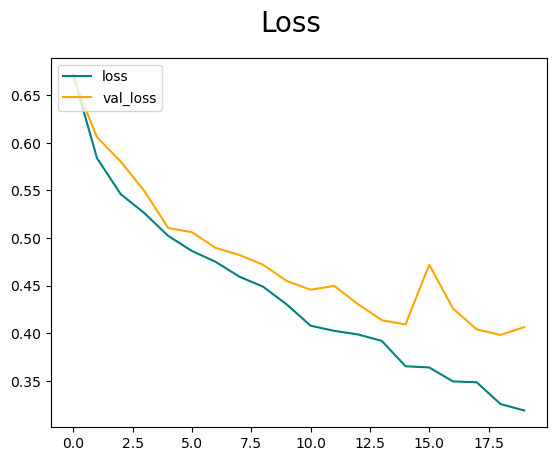

In [38]:
# Plot the loss
fig = plt.figure()
plt.plot(hist_initial.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist_initial.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

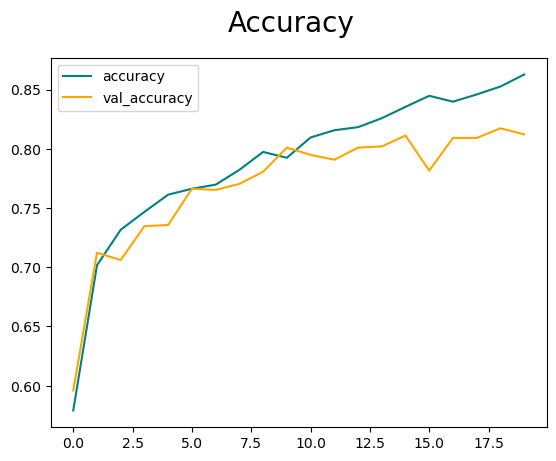

In [39]:
# Plot the accuracy
fig = plt.figure()
plt.plot(hist_initial.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist_initial.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

In [40]:
# Run evaluation metrics on the test dataset
for batch in test.as_numpy_iterator():
    X,y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 27ms/step


In [41]:
# Print Precision, Recall, and Accuracy
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.7982832789421082, Recall:0.8017241358757019, Accuracy:0.8070539236068726


In [42]:
# Print the final Accuracy
check = model.evaluate(test)

49/49 [==============================] - 3s 24ms/step - loss: 0.3988 - accuracy: 0.8195


Our testing accuracy of our model is 81.95% - our model accuratly predicts over 81% of the time. 

Precision is .7983, meaning that of the records we classify as not having a mannequin, almost 80% actually do not contain a mannequin. 

Recall is .8017, this tells us that of the records that don't contain a mannequin, over 80% of them are classified correctly.

# 6. Save Model

In [44]:
model.save(os.path.join('models', 'MannequinClass_1_0.h5'))

# A. APPENDIX

#### For any additional modeling notes, reference the 2. Model Training notebook associated with this notebook.

#### For any additional information visit my GitHub - https://github.com/chase-weber/Mannequin-Image-Detection